### Imports 

In [1]:
import json
from pymongo import MongoClient
import pandas as pd
import nltk
import numpy as np
import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import paired_euclidean_distances
import lda
from numpy.random import choice
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Upload data to MongoDB

In [7]:
client = MongoClient()
db = client.food_db
# Our collection: 
reviews_10 = db.food_collections10

In [8]:
foods = []

def read_file(path):
    with open(path, 'r') as file:
        return file.read()

In [9]:
text = read_file('finefoods.txt')
text=text.decode('utf-8','ignore').encode("utf-8")
text_new = text.split('\n\n')

In [10]:
#make data into a dictionary

for i in text_new:
    group=i.split('\n')
    my_dict={}
    for j in group:
        if 'product/productId:' in j:
            value=j.split(': ')[1]
            my_dict['productId']=value
        if 'review/userId' in j:
            value=j.split(': ')[1]
            my_dict['userId']=value
        if 'review/profileName' in j:
            value=j.split(': ')[1]
            my_dict['profileName']=value
        if 'review/helpfulness' in j:
            value=j.split(': ')[1]
            my_dict['helpfulness']=value
        if 'review/score' in j:
            value=j.split(': ')[1]
            my_dict['score']=value
        if 'review/summary' in j:
            value=j.split(': ')[1]
            my_dict['summary']=value
        if 'review/text' in j:
            value=j.split(': ')[1]
            my_dict['text']=value
    reviews_10.insert_one(my_dict)

In [11]:
print reviews_10

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'food_db'), u'food_collections10')


In [12]:
print len(text_new)

568455


In [13]:
reviews_10.count()

568455

In [14]:
my_reviews = reviews_10
print my_reviews.count()

568455


In [15]:
print my_reviews

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'food_db'), u'food_collections10')


### Convert to DataFrame

In [16]:
columns = ['productId', 'userId', 'profileName', 'helpfulness', 'score', 'summary', 'text']

df = pd.DataFrame(columns=columns)

In [17]:
cursor_productId = my_reviews.find({}, {'productId':1})
df['productId'] = list(cursor_productId)

cursor_userId = my_reviews.find({}, {'userId':1})
df['userId'] = list(cursor_userId)

cursor_profileName = my_reviews.find({}, {'profileName':1})
df['profileName'] = list(cursor_profileName)

cursor_helpfulness = my_reviews.find({}, {'helpfulness':1})
df['helpfulness'] = list(cursor_helpfulness)

cursor_score = my_reviews.find({}, {'score':1})
df['score'] = list(cursor_score)

cursor_summary = my_reviews.find({}, {'summary':1})
df['summary'] = list(cursor_summary)

cursor_text = my_reviews.find({}, {'text':1})
df['text'] = list(cursor_text)

In [18]:
#make labels for the DataFrame

def get_label(series,label):
    try:
        return series[label]
    except:
        return ''
    
for col in ['productId','userId','profileName','helpfulness','score','summary','text']:
    df[col] = df[col].apply(lambda x: get_label(x, col))

In [19]:
df.head(2)

,productId,userId,profileName,helpfulness,score,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [20]:
df['text'].dtypes

dtype('O')

In [21]:
#add a column to indicate a five star review

df['five'] = np.where(df['score']=='5.0', True, False)
df.head(2)

,productId,userId,profileName,helpfulness,score,summary,text,five
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,True
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,False


In [22]:
df_five = df

df_five = df_five[df_five.five]
len(df_five)

363122

In [23]:
df_five = df_five.reindex(np.random.permutation(df_five.index))

In [24]:
df_five.head(2)

,productId,userId,profileName,helpfulness,score,summary,text,five
379867,B001O8PKV6,AKACGHPVILE9R,"Sophronia ""Euphemia""",2/3,5.0,Organic Glass Great Packaging & Taste,"This is a great product, the taste is great, t...",True
490578,B000CQE3IC,AQLL2R1PPR46X,grumpyrainbow,5/7,5.0,I guess not for everyone.,"Well, the 1 star reviews are from people who n...",True


In [25]:
df_five = df_five.drop(df_five.index[5000:])
len(df_five)

5000

In [26]:
#df['text'] = df['text'].astype('str') 

## NLTK

### Sentence

In [75]:
#breaks the text up into sentences

from nltk.tokenize import sent_tokenize

sentences = [sent_tokenize(x.lower()) for x in df_five['text']]
print sentences[0]

[u'this is a great product, the taste is great, the seller really packages well, i was concerned about the glass breaking, not one casualty.', u'and it is organic!', u'yes!', u'and the price is competitive.']


### Words

In [76]:
#breaks the text up into words

from nltk.tokenize import word_tokenize

words = [word_tokenize(x) for x in df_five['text']]
print words[0]

[u'This', u'is', u'a', u'great', u'product', u',', u'the', u'taste', u'is', u'great', u',', u'the', u'seller', u'really', u'packages', u'well', u',', u'I', u'was', u'concerned', u'about', u'the', u'glass', u'breaking', u',', u'not', u'one', u'casualty', u'.', u'And', u'it', u'is', u'organic', u'!', u'Yes', u'!', u'And', u'the', u'price', u'is', u'competitive', u'.']


## Parts of Speech Tagging

In [29]:
from nltk.tag import pos_tag
word_tags = word_tokenize(df['text'].str.lower()[0])
pos_tag(word_tags)

[(u'i', 'NNS'),
 (u'have', 'VBP'),
 (u'bought', 'VBN'),
 (u'several', 'JJ'),
 (u'of', 'IN'),
 (u'the', 'DT'),
 (u'vitality', 'NN'),
 (u'canned', 'VBD'),
 (u'dog', 'JJ'),
 (u'food', 'NN'),
 (u'products', 'NNS'),
 (u'and', 'CC'),
 (u'have', 'VBP'),
 (u'found', 'VBN'),
 (u'them', 'PRP'),
 (u'all', 'DT'),
 (u'to', 'TO'),
 (u'be', 'VB'),
 (u'of', 'IN'),
 (u'good', 'JJ'),
 (u'quality', 'NN'),
 (u'.', '.'),
 (u'the', 'DT'),
 (u'product', 'NN'),
 (u'looks', 'VBZ'),
 (u'more', 'RBR'),
 (u'like', 'IN'),
 (u'a', 'DT'),
 (u'stew', 'NN'),
 (u'than', 'IN'),
 (u'a', 'DT'),
 (u'processed', 'JJ'),
 (u'meat', 'NN'),
 (u'and', 'CC'),
 (u'it', 'PRP'),
 (u'smells', 'VBZ'),
 (u'better', 'RBR'),
 (u'.', '.'),
 (u'my', 'PRP$'),
 (u'labrador', 'NN'),
 (u'is', 'VBZ'),
 (u'finicky', 'JJ'),
 (u'and', 'CC'),
 (u'she', 'PRP'),
 (u'appreciates', 'VBZ'),
 (u'this', 'DT'),
 (u'product', 'NN'),
 (u'better', 'JJR'),
 (u'than', 'IN'),
 (u'most', 'JJS'),
 (u'.', '.')]

## Count Vectorizer

In [30]:
tmp = [i.lower() for i in df_five['text']]

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(tmp)
X

<5000x13217 sparse matrix of type '<type 'numpy.int64'>'
	with 136252 stored elements in Compressed Sparse Row format>

In [82]:
vect = vectorizer.get_feature_names()

In [33]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Bi-Grams

In [34]:
bigram_vectorizer = CountVectorizer(stop_words= 'english', ngram_range=(2,2),min_df=1)
bigram_vectorizer.fit_transform(tmp[:10]).toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

In [88]:
#bigrams break down the text into popular two word phrases

bigram_vectorizer.get_feature_names()[100:110]

[u'cut loaf',
 u'cut warm',
 u'daily good',
 u'days br',
 u'decaf earl',
 u'decided order',
 u'decided try',
 u'dedicated gluten',
 u'did cost',
 u'didnt add']

## TF IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit_transform(tmp).toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Distance

In [37]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import paired_euclidean_distances

print cosine_distances(X[0], X[1])
print paired_euclidean_distances(X[0], X[1])

[[ 0.93273272]]
[ 8.06225775]


## Dendrogram

In [62]:
from nltk.stem.porter import PorterStemmer

'''
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems
'''

stopwords = [i for i in nltk.corpus.stopwords.words('english')]
stopwords.extend(['amazon', 'product', 'br', 'one', 'use', 'always', 'get', 'also', 'far', 'give',
                 'foods', 'dogs', 'loves', 'two', 'treats'])

#'thi', 'wa', ',', '>', '<', '/', '!', "'s", "''", ')'
tfidf = TfidfVectorizer(max_df=0.8, max_features=10000,
                       min_df=0.03, stop_words=stopwords, use_idf=True)

tfidf_matrix = tfidf.fit_transform(tmp)

In [63]:
tfidf_matrix.shape

(5000, 169)

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(tfidf_matrix.toarray(), 'average')

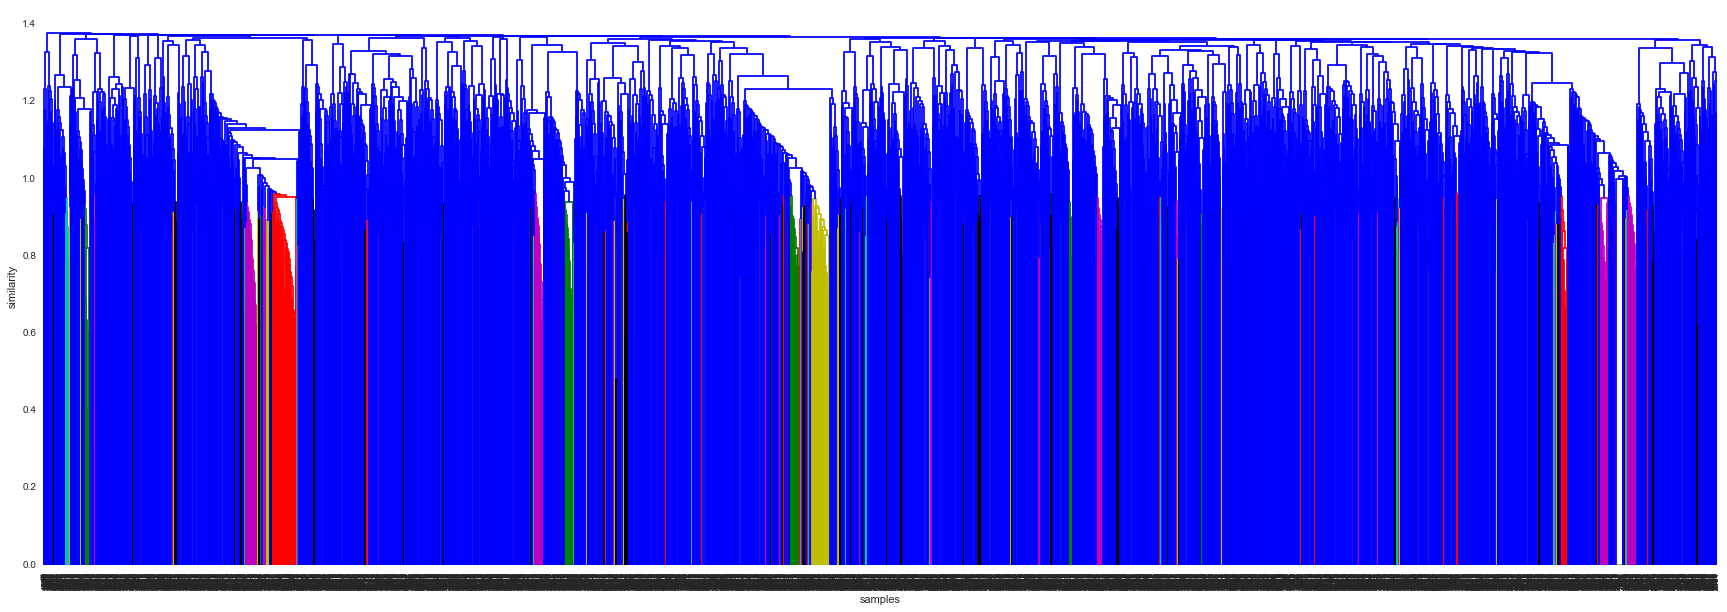

In [65]:
#dendograms are a form of tree diagram showing taxonomic relationships

plt.figure(figsize=(30, 10))
plt.xlabel('samples')
plt.ylabel('similarity')

dendrogram(Z, leaf_rotation=90., leaf_font_size=8.,)

plt.show()

### PCA

In [66]:
from sklearn.decomposition import PCA

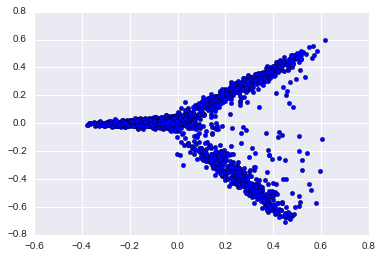

array([ 0.02537074,  0.02436769,  0.01755844,  0.01648365,  0.01512777,
        0.01399161,  0.0133457 ,  0.01223601,  0.01136038,  0.01108366,
        0.01076918,  0.01038144,  0.00990546,  0.00965405,  0.00950437,
        0.00926118,  0.00913843,  0.009073  ,  0.00893015,  0.00843597,
        0.00834885,  0.00818046,  0.00805344,  0.00795932,  0.00779865,
        0.00769982,  0.00755107,  0.00741563,  0.00737907,  0.00725379,
        0.00714618,  0.00709887,  0.0070629 ,  0.00700082,  0.00686528,
        0.00681771,  0.00678184,  0.00666136,  0.00662811,  0.00653717,
        0.00653136,  0.00647667,  0.00642048,  0.00635677,  0.00628524,
        0.00628186,  0.00622071,  0.00612342,  0.00603858,  0.00600115,
        0.00597831,  0.00594577,  0.00590722,  0.00580948,  0.00579462,
        0.0056771 ,  0.00566482,  0.00559484,  0.00553713,  0.00551552,
        0.00549337,  0.00541486,  0.00539763,  0.00534425,  0.00530681,
        0.0052923 ,  0.00521686,  0.00517979,  0.00515903,  0.00

In [67]:
pca = PCA(n_components=100).fit(tfidf_matrix.toarray())
data2D = pca.transform(tfidf_matrix.toarray())
plt.scatter(data2D[:,0], data2D[:,1])
plt.show()
pca.explained_variance_

## Top 10 Words

In [89]:
dense_matrix = tfidf_matrix.todense()
dense_df = pd.DataFrame(dense_matrix)
dense_df.columns = tfidf.get_feature_names()
#dense_df = dense_df.drop('years', 1)
dense_df.head(2)

,actually,add,almost,another,anything,around,back,bag,bags,best,...,way,well,whole,without,wonderful,work,worth,would,year,years
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.371149,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.190806,0.0,0.182192,0.0,0.0,0.0,...,0.0,0.281373,0.18018,0.0,0.0,0.0,0.0,0.270993,0.0,0.165458


### K Means

In [70]:
#K Means is an unsupervised learning algorithm. It clusters the words into distinct groups.

from sklearn.cluster import KMeans

n_clusters=5
clusters=KMeans(n_clusters).fit_predict(dense_matrix)

In [71]:
dense_df['clusters'] = clusters

In [72]:
dense_df.head(20)

,actually,add,almost,another,anything,around,back,bag,bags,best,...,well,whole,without,wonderful,work,worth,would,year,years,clusters
0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.371149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.0,0.00000,0.0,0.000000,0.190806,0.000000,0.182192,0.0,0.000000,0.000000,...,0.281373,0.180180,0.000000,0.000000,0.000000,0.000000,0.270993,0.000000,0.165458,2
2,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.422840,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.288982,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
6,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.228766,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289681,2
7,0.0,0.00000,0.0,0.269944,0.265240,0.000000,0.000000,0.0,0.000000,0.181639,...,0.000000,0.000000,0.000000,0.000000,0.257716,0.267007,0.188354,0.000000,0.000000,2
8,0.0,0.17173,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.130243,...,0.140232,0.000000,0.000000,0.000000,0.184794,0.000000,0.000000,0.000000,0.000000,2
9,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.099332,0.0,0.000000,0.071240,...,0.000000,0.098236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090209,2


In [74]:
print 'These are the 5 top clusters of types of Amazon five star reviews:'

for i in range(n_clusters):
    print i
    print(dense_df.groupby('clusters').mean().iloc[i].sort_values(ascending = False)[:10])

These are the 5 top clusters of types of Amazon five star reviews:
0
great     0.293277
love      0.059932
taste     0.053704
price     0.050476
good      0.046711
flavor    0.038905
snack     0.038183
buy       0.034918
time      0.029731
really    0.029722
Name: 0, dtype: float64
1
dog        0.298844
food       0.281999
love       0.054214
eat        0.049524
good       0.047902
treat      0.047129
like       0.044019
quality    0.038528
great      0.038125
old        0.036182
Name: 1, dtype: float64
2
like      0.060298
good      0.060248
love      0.051579
taste     0.044084
best      0.041385
flavor    0.040074
really    0.037108
find      0.036870
would     0.031285
much      0.031218
Name: 2, dtype: float64
3
coffee     0.472657
cup        0.108794
like       0.067886
good       0.064423
strong     0.059881
flavor     0.057617
great      0.054212
taste      0.053451
love       0.048512
morning    0.039605
Name: 3, dtype: float64
4
tea       0.528966
green     0.072614
love     